# Project 6 - Product Recommendations using Word2Vec - Training the recommendation model

- Training the recommendation model


- Course Name :         Applied Machine Learning
- Course instructor:    Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 6 -           Product Recommendations using Word2Vec
- Date :                September 2024
- File(ipynb) :         3/3

## Step 1: Install required libraries

In [1]:
%pip install numpy pandas matplotlib seaborn plotly tqdm gensim umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


## Step 2: Import required libraries

In [2]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from gensim.models import Word2Vec
import umap

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Step 3 : Load and Prepare data

In [3]:
# Load dataset
dataset_path = '/content/drive/My Drive/Applied Machine Learning/Project 6 : Product Recommendations using Word2Vec/datasets/cleaned_OnlineRetail.csv'
# dataset_path = r'C:\Users\Afshin\Desktop\10_Projects\Project_6_Product_Recommendations_using_Word2Vec\datasets\cleaned_OnlineRetail.csv'

df = pd.read_csv(dataset_path)
df.info()
print(f'> Shape of the dataset is {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339928 entries, 0 to 339927
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    339928 non-null  object 
 1   StockCode    339928 non-null  object 
 2   Description  339928 non-null  object 
 3   Quantity     339928 non-null  int64  
 4   InvoiceDate  339928 non-null  object 
 5   UnitPrice    339928 non-null  float64
 6   CustomerID   339928 non-null  float64
 7   Country      339928 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 20.7+ MB
> Shape of the dataset is (339928, 8)


In [4]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
145861,558709,22178,VICTORIAN GLASS HANGING T-LIGHT,6,2011-07-01 13:02:00,1.25,17338.0,United Kingdom
43708,543300,84637,KITCHEN FLOWER POTS WALL PLAQUE,1,2011-02-07 11:42:00,5.95,13334.0,United Kingdom
30730,541281,22555,PLASTERS IN TIN STRONGMAN,1,2011-01-17 11:59:00,1.65,17988.0,United Kingdom
198506,566053,23309,SET OF 60 I LOVE LONDON CAKE CASES,2,2011-09-08 14:57:00,0.55,14410.0,United Kingdom
21991,539957,21211,SET OF 72 SKULL PAPER DOILIES,12,2010-12-23 12:58:00,1.45,12585.0,Germany


## Step 4 : Shuffle customers and split the dataset

In [5]:
train_rate = 0.9

# Check out the number of unique customers in our dataset
customers = df['CustomerID'].unique().tolist()

# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
split_index = int(len(customers) * train_rate)
customers_train = customers[:split_index]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

print(f'> Number of Train samples is {len(train_df)}.')
print(f'> Number of Test  samples is {len(validation_df)}.')

> Number of Train samples is 300480.
> Number of Test  samples is 39448.


## Step 5 : Create purchase history sequences

In [6]:
def create_purchase_sequences(df, customer_ids):
    return [df[df["CustomerID"] == customer_id]["StockCode"].tolist() for customer_id in tqdm(customer_ids)]

purchases_train = create_purchase_sequences(train_df, customers_train)
purchases_validation = create_purchase_sequences(validation_df, validation_df['CustomerID'].unique())

100%|██████████| 423/423 [00:00<00:00, 2070.08it/s]


In [7]:
print(f'> Number of Train Purchases is {len(purchases_train)}.')
print(f'> Number of Test  Purchases is {len(purchases_validation)}.')

> Number of Train Purchases is 3801.
> Number of Test  Purchases is 423.


- Check features and their values

In [8]:
def display_unique_feature_values(df:pd.DataFrame):
    columns = df.columns.tolist()
    for column in columns:
        values = df[column].unique().tolist()
        print(f'> {column} : {len(values)} -> {values}')

In [9]:
display_unique_feature_values(df)

> InvoiceNo : 19604 -> ['536365', '536366', '536367', '536368', '536369', '536370', '536372', '536373', '536375', '536377', '536378', '536380', '536381', '536382', 'C536383', '536384', '536385', '536388', '536389', '536390', 'C536391', '536392', '536394', '536395', '536396', '536397', '536398', '536399', '536400', '536401', '536404', '536406', '536407', '536408', '536409', '536412', '536415', '536416', '536420', '536423', '536425', '536446', '536460', '536463', '536464', '536466', '536477', '536488', '536500', '536502', 'C536506', '536514', '536520', '536521', '536522', '536523', '536524', '536525', '536526', '536527', '536528', '536529', '536530', '536531', '536532', '536533', '536534', '536535', '536536', '536537', '536538', '536539', '536540', '536541', '536542', 'C536543', 'C536548', '536551', '536556', '536557', '536559', '536560', '536561', '536562', '536563', '536564', '536566', '536567', '536568', '536569', '536570', '536571', '536572', '536573', '536574', '536576', '536578', '

- Display unique countries

In [10]:
fig = px.histogram(df, x="Country")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Step 6 : Train Word2Vec model

- train word2vec model

In [11]:
model = Word2Vec(sentences=purchases_train, vector_size=100, window=10, sg=1, hs=0,
                 negative=10, epochs=10, seed=14)

# Make the model memory efficient
model.init_sims(replace=True)
print(model)

Word2Vec<vocab=2871, vector_size=100, alpha=0.025>


- Save the word2vec model

In [ ]:
model_path = '/content/drive/My Drive/Applied Machine Learning/Project 6 : Product Recommendations using Word2Vec/models/word2vec_model.model'
# model_path = r'C:\Users\Afshin\Desktop\10_Projects\Project_6_Product_Recommendations_using_Word2Vec\models\word2vec_model.model'

model.save(model_path)
print(f'> The word2vec model saved to {model_path}.')

> The word2vec model saved to C:\Users\Afshin\Desktop\10_Projects\Project_6_Product_Recommendations_using_Word2Vec\models\word2vec_model.model.


## Step 7 : Validate results

- Prepare product descriptions

In [12]:
print(f'> Number of Train samples before handling StockCode duplicates is {len(train_df)}')
products = train_df[["StockCode", "Description"]].drop_duplicates(subset='StockCode')
print(f'> Number of products after handling StockCode duplicates is {len(products)}')
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

> Number of Train samples before handling StockCode duplicates is 300480
> Number of products after handling StockCode duplicates is 3372


- Function to get similar products

In [13]:
def similar_products(product_id, n=6):
    try:
        similar_items = model.wv.similar_by_key(product_id, topn=n + 1)[1:]  # Exclude the product itself
        return [(products_dict[item[0]][0], item[1]) for item in similar_items]
    except KeyError:
        return []

- Aggregating vectors from product IDs

In [14]:
def aggregate_vectors(product_ids):
    valid_vectors = [model.wv[pid] for pid in product_ids if pid in model.wv.key_to_index]
    return np.mean(valid_vectors, axis=0) if valid_vectors else None

- Validate results

In [15]:
recommendation = similar_products('90019A')
print(recommendation)

[('DIAMANTE NECKLACE PURPLE', 0.6848376989364624), ('FRENCH LATTICE CUSHION COVER ', 0.6706485748291016), ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.6612347960472107), ('RELAX LARGE WOOD LETTERS', 0.6534705758094788), ('ANT SILVER LIME GREEN BOUDICCA RING', 0.6521778106689453), ('NUMBER TILE VINTAGE FONT 7', 0.6511830687522888)]


- Example of user aggregate

In [16]:
user_vector = aggregate_vectors(purchases_validation[0])
if user_vector is not None:
    recommendations = similar_products(user_vector)
    print(recommendations)

[('LARGE MINT DIAMANTE HAIRSLIDE', 0.6725968718528748), ('PINK POLKADOT WRAP ', 0.6719706058502197), ('WRAP ENGLISH ROSE ', 0.6659872531890869), ('RED RETROSPOT WRAP ', 0.6649776697158813), ('WRAP DOILEY DESIGN', 0.660157322883606), ('BLUE POLKADOT WRAP', 0.6471781730651855)]


In [17]:
user_last_ten_vector = aggregate_vectors(purchases_validation[0][-10:])
if user_last_ten_vector is not None:
    last_ten_recommendations = similar_products(user_last_ten_vector)
    print(last_ten_recommendations)

[('SQUARECUSHION COVER PINK UNION FLAG', 0.6789649724960327), ('PINK BITTY LIGHT CHAIN', 0.6670240163803101), ('LILAC GAUZE BUTTERFLY LAMPSHADE', 0.628512978553772), ('WALL ART GARDEN HAVEN ', 0.6219802498817444), ('WALL ART THE MAGIC FOREST ', 0.618781566619873), ('WOVEN FROST CUSHION COVER', 0.6173411011695862)]


## Step 8 : Visualize embeddings using UMAP

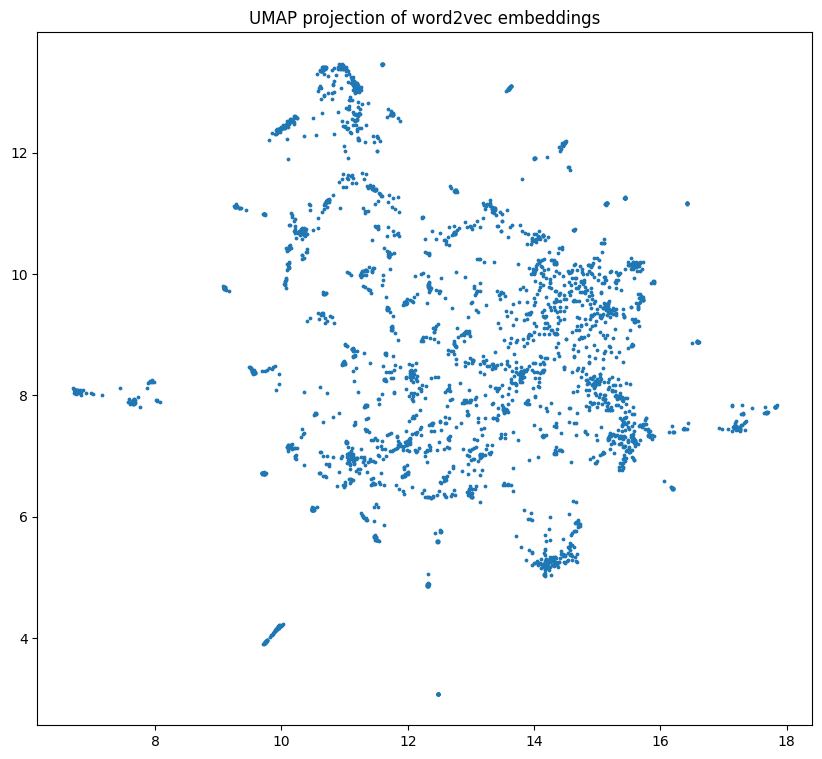

In [18]:
X = model.wv.vectors
umap_embeddings = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(10, 9))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')
plt.title('UMAP projection of word2vec embeddings')
plt.show()